# Data Processing

A look at the dataset.

In [ ]:
import pandas as pd
data = pd.read_csv('Data/train.csv')
data.sample(2)

,Image,target
153,512.jpg,odissi
259,452.jpg,odissi


Split into train and validation data

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(data, test_size = 0.13, random_state = 19)

Create new directories to store processed train, validation and test images.

In [ ]:
os.mkdir('Data/final_train')
os.mkdir('Data/final_test')
os.mkdir('Data/final_val')

dance_forms = data['target'].unique().tolist()
for i in dance_forms:
  os.mkdir('Data/final_train/'+i)
  os.mkdir('Data/final_val/'+i)

Copy images to their respective directories.

In [ ]:
import shutil

s = 'Data/train/'
d1 = 'Data/final_train/'
d2 = 'Data/final_val/'

train_im = train['Image'].array
train_t = train['target'].array
for i in range(0, len(train_im)):
  im = train_im[i]
  target = train_t[i]
  shutil.copy(s + im, d1 + target + '/' + im)

val_im = val['Image'].array
val_t = val['target'].array
for i in range(0, len(val)):
  im = val_im[i]
  target = val_t[i]
  shutil.copy(s + im, d2 + target + '/' + im)

test = pd.read_csv('test.csv')
for im in test['Image'].array:
  shutil.copy('Data/test/' + im, 'Data/final_test/' + im)

# Image Augmentations
There are only 316 images in the training set. It will hard to get a good model using just those. We will apply augmentations, to improve the accuracy.

In [ ]:
import os
import cv2
from PIL import Image

Create two functions:
*   resize : To resize all images to specification.
*   add_padding: To add padding to non square images.

In [ ]:
def resize(s,src,des):
  size = s,s
  for fname in os.listdir(src):
    spath = os.path.join(src+fname)
    dpath = os.path.join(des+fname)
    if os.path.isfile(spath):
      image = Image.open(spath)
      image.thumbnail(size, Image.ANTIALIAS)
      image.save(dpath)

def add_padding(s,src,des):
  for fname in os.listdir(src):
    spath = os.path.join(src+fname)
    dpath = os.path.join(des+fname)
    if os.path.isfile(spath):
      im = Image.open(spath)
      desired_size = s
      old_size = im.size
      ratio = float(desired_size)/max(old_size)
      new_size = tuple([int(x*ratio) for x in old_size])
      im = im.resize(new_size, Image.ANTIALIAS)
      new_im = Image.new("RGB", (desired_size, desired_size))
      new_im.paste(im, ((desired_size-new_size[0])//2,(desired_size-new_size[1])//2))
      new_im.save(dpath)

Resize and pad all images.

In [ ]:
dance_forms = [i+'/' for i in dance_forms]

for i in ['Data/final_train/','Data/final_val/']:
  for j in dance_forms:
    resize(512, i + j, i + j)
    add_padding(512, i + j, i + j)

k = 'Data/final_test/'
resize(512, k, k)
add_padding(512, k, k)

Functions for image augmentations.

In [ ]:
import random
from scipy import ndarray
import skimage as sk
from skimage import transform, util, io

# Random rotation within specified upper and lower degree bounds
def random_rotation(image_array: ndarray, lb, ub):
  random_degree = random.uniform(lb, ub)
  return sk.transform.rotate(image_array, random_degree)

# Random noise into the image
def random_noise(image_array: ndarray):
  return sk.util.random_noise(image_array)

# Horizontal Flip
def horizontal_flip(image_array: ndarray):
  return image_array[:, ::-1]

# Bluring the image
def blur_image(image):
  return cv2.GaussianBlur(image, (9,9),0)

# Shift pixels by an offset
def warp_shift(image): 
  transform = sk.transform.AffineTransform(translation=(10, 10))
  warp_image = sk.transform.warp(image, transform, mode="wrap")
  return warp_image

# Gray image
def gray(image):
  return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

Perform augmentations on all images. 

The following code will create 6 new images from one image. The number of training images will then be 7 times the original.

In [ ]:
for i in dance_forms:
  aug = 0
  folder_path = os.path.join('Data/final_train/',i+'/')
  for fname in os.listdir(folder_path):
    if os.path.isfile(folder_path + fname):
      image_to_transform = sk.io.imread(folder_path + fname)
      #1
      transformed_image = horizontal_flip(image_to_transform)
      transformed_image = blur_image(transformed_image)
      aug += 1
      io.imsave(folder_path + 'aug' + str(aug) + '.jpg', transformed_image)
      #2
      transformed_image = random_rotation(image_to_transform, -45, 0)
      transformed_image = random_noise(transformed_image)
      aug += 1
      io.imsave(folder_path + 'aug' + str(aug) + '.jpg', transformed_image)
      #3
      transformed_image = horizontal_flip(transformed_image)
      transformed_image = blur_image(transformed_image)
      aug += 1
      io.imsave(folder_path + 'aug' + str(aug) + '.jpg', transformed_image)
      #4
      transformed_image = random_rotation(image_to_transform, 0 ,45)
      transformed_image = random_noise(transformed_image)
      aug += 1
      io.imsave(folder_path + 'aug' + str(aug) + '.jpg', transformed_image)
      #5
      transformed_image = horizontal_flip(transformed_image)
      transformed_image = blur_image(transformed_image)
      aug += 1
      io.imsave(folder_path + 'aug' + str(aug) + '.jpg', transformed_image)
      #6
      transformed_image = gray(image_to_transform)
      transformed_image = warp_shift(transformed_image)
      aug += 1
      io.imsave(folder_path + 'aug' + str(aug) + '.jpg', transformed_image)

# Fast AI Model
We use a pre trained model to get better results and save time on training.

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy, error_rate
defaults.device = torch.device('cuda')

Process images for training with a suitable batch size.

In [ ]:
data = ImageDataBunch.from_folder(path = Path.cwd(), train = 'Data/final_train', valid = 'Data/final_val', test = 'Data/final_test', 
                                  ds_tfms = get_transforms(do_flip = False, flip_vert = False, max_rotate = 0, max_zoom = 1.0, max_lighting = 0.2),
                                  size=512, bs = 8).normalize(imagenet_stats)

Train Sample:


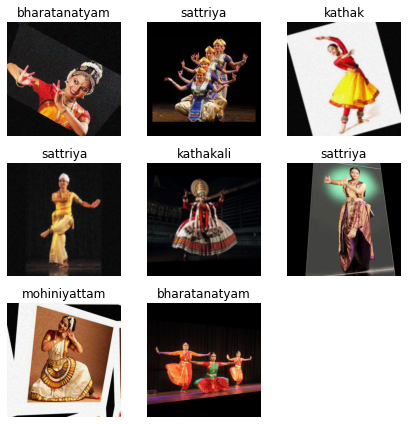

In [ ]:
print('Train Sample:')
data.show_batch(rows=3, figsize=(6,6), ds_type = DatasetType.Train)

Validation Sample:


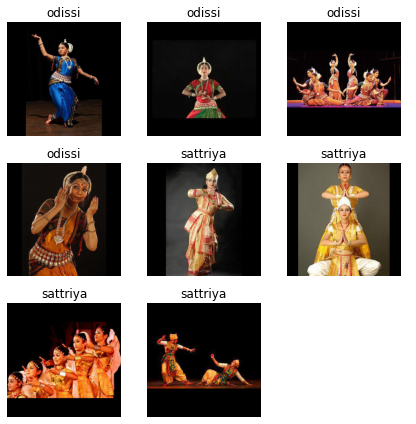

In [ ]:
print('Validation Sample:')
data.show_batch(rows=3, figsize=(6,6), ds_type = DatasetType.Valid)

Test Sample:


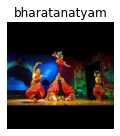

In [ ]:
print('Test Sample:')
data.show_batch(rows=1, figsize=(6,2), ds_type = DatasetType.Test)

Choose a pre trained model. The model used here is densenet121.

In [ ]:
cnn = create_cnn(data, models.densenet121 , metrics = [accuracy, error_rate])

Fit images

In [ ]:
cnn.fit_one_cycle(12)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.701706,1.484385,0.541667,0.458333,01:16
1,1.055374,1.054972,0.625000,0.375000,01:15
2,0.762143,0.823630,0.750000,0.250000,01:14
3,0.565306,0.911313,0.791667,0.208333,01:14
4,0.410551,1.184821,0.708333,0.291667,01:13
5,0.303798,1.042582,0.750000,0.250000,01:14
6,0.212974,1.085495,0.770833,0.229167,01:15
7,0.149569,1.158725,0.750000,0.250000,01:14
8,0.164868,0.989058,0.770833,0.229167,01:14
9,0.138237,0.934997,0.770833,0.229167,01:15


The train_loss was decreased from 1.70 to 0.08 with an 80% accuracy on the validation data. This also means that there isn't over-fitting and it's a good model.

Perform predictions.

In [ ]:
cnn.data=data
preds, y = cnn.get_preds(ds_type=DatasetType.Test)
preds = np.argmax(preds, axis = 1)
preds_classes = [data.classes[i] for i in preds]

In [ ]:
import os
solution = pd.DataFrame({ 'Image': os.listdir('Data/final_test/'), 'target': preds_classes })
solution.to_csv('Data/test.csv',index = False)

The predictions had an accuracy of 88.3% on the leaderboard.